### Motivation
This dataset contains citywide payroll information for government jobs in NYC. We are interested in understanding more about NYC salaries and potentially develop a model in order to predict gross pay. In order to do so we perform a exploratory data analysis of the dataset to figure out which features of interest we want to use in our models. We will also have to do preprocessing and handling categorical data and convert them into numerical data for our model to use.

#### Importing libraries and Data Set

In [1]:
#!/usr/bin/env python

# https://dev.socrata.com/foundry/data.cityofnewyork.us/k397-673e
# make sure to install these packages before running:
# pip install pandas
# pip install sodapy

%pip install pandas
%pip install sodapy
%pip install seaborn
%pip install matplotlib

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sodapy import Socrata
import numpy as np

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 10000000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("k397-673e", limit=1000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

You should consider upgrading via the '/home/salman1567/code/Data Science - Machine Learning Projects/NYC_payroll/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/salman1567/code/Data Science - Machine Learning Projects/NYC_payroll/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/salman1567/code/Data Science - Machine Learning Projects/NYC_payroll/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/salman1567/code/Data Science - Machine Learning Projects/NYC_payroll/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Part I: Data Exploration

In [2]:
# Checking the type for each of the columns
# We will find that all of the columns seem to be objects so we need to convert some to numeric later on or just drop
# them if not interested in them

results_df.dtypes

fiscal_year                   object
payroll_number                object
agency_name                   object
last_name                     object
first_name                    object
mid_init                      object
agency_start_date             object
work_location_borough         object
title_description             object
leave_status_as_of_july_31    object
base_salary                   object
pay_basis                     object
regular_hours                 object
regular_gross_paid            object
ot_hours                      object
total_ot_paid                 object
total_other_pay               object
dtype: object

In [3]:
# Convert the leave_status_as_of_july_31 feature as 0 or 1


In [4]:
# Lets examine how much data we have for each of the fiscal year

unique_years = results_df['fiscal_year'].unique()
unique_years

for i in unique_years:
    print(i, ' - Number of Rows: ', results_df[results_df['fiscal_year'] == i].shape[0])


2021  - Number of Rows:  130750
2020  - Number of Rows:  128406
2019  - Number of Rows:  131457
2018  - Number of Rows:  124622
2017  - Number of Rows:  142445
2016  - Number of Rows:  116483
2015  - Number of Rows:  115347
2014  - Number of Rows:  110490


In [5]:
# Lets see how much missing data there is
# There is 17 rows that is missing the title description, 
# work_location_borough and agency_start_date which is a feature we are interested in
# Other features like payroll_number, name, mid_init we aren't interested in for this data exploration

results_df.isna().sum()



fiscal_year                        0
payroll_number                375210
agency_name                        0
last_name                        257
first_name                       259
mid_init                      479098
agency_start_date                 63
work_location_borough         109555
title_description                 17
leave_status_as_of_july_31         0
base_salary                        0
pay_basis                          0
regular_hours                      0
regular_gross_paid                 0
ot_hours                           0
total_ot_paid                      0
total_other_pay                    0
dtype: int64

#### Preprocessing
We need to convert datatypes into numerical values so that we can manipulate them and create some summary statistics and do feature engineering

In [6]:
# Drop base_salary and pay_basis since they are features that are already incorporated in regular_gross_paid
results_df = results_df.drop(columns=['base_salary', 'pay_basis'])

In [7]:

# We will also drop some rows that have mistyped 60157.150.004245.78 as the regular_gross_paid
# Using regular expression to remove strings that have more than one decimal point in them

reg_pattern = "(\.[a-z]){2,}"
filter_pattern = results_df['regular_gross_paid'].str.contains(reg_pattern)
results_df = results_df[~filter_pattern]

convert_to_numeric = ['regular_hours', 'regular_gross_paid', 'ot_hours', 'total_ot_paid', 'total_other_pay']

for i in convert_to_numeric:
    results_df[i] = pd.to_numeric(results_df[i]) 



/tmp/ipykernel_362682/3537614432.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filter_pattern = results_df['regular_gross_paid'].str.contains(reg_pattern)


In [8]:
# Check to see if the features have been properly converted
results_df.dtypes

fiscal_year                    object
payroll_number                 object
agency_name                    object
last_name                      object
first_name                     object
mid_init                       object
agency_start_date              object
work_location_borough          object
title_description              object
leave_status_as_of_july_31     object
regular_hours                 float64
regular_gross_paid            float64
ot_hours                      float64
total_ot_paid                 float64
total_other_pay               float64
dtype: object

In [9]:
for i in unique_years:
    print(i, ' - Number of Rows: ', results_df[results_df['fiscal_year'] == i].shape[0])

results_df.shape[0]

2021  - Number of Rows:  130750
2020  - Number of Rows:  128406
2019  - Number of Rows:  131457
2018  - Number of Rows:  124622
2017  - Number of Rows:  142445
2016  - Number of Rows:  116483
2015  - Number of Rows:  115347
2014  - Number of Rows:  110490


1000000

#### Feature Engineering

We are mostly interested in knowing total gross pay of these jobs: Regular Gross Paid + Total OT Paid + Total Other Pay. Therefore we will make a calculated field called total_gross_pay. We also need to convert these data types to numeric since python has read them in as strings. We can also potentially drop base_salary and pay_basis since those are implicitely included in regular_gross_paid. We can also calculate another feature called ot_paid_ per_hour from the features total_ot_paid and ot_hours. This way we can know how much their over time pay is per hour depending on their job. Which would be an interesting thing to know.

We can also create a new feature to identify men and female from the first and last name and segment the data into men and women to see if there is homogeneity or not. (If men makes more money than women)

> Total Gross Pay

The total Gross Pay will be the regular gross paid plus any total over time paid plus any miscellanous pay.

In [10]:
# Creating a new column: total_gross_pay = regular_gross_pay + total_OT_paid + Total_Other_Pay

results_df['total_gross_pay'] = results_df['regular_gross_paid'] + results_df['total_ot_paid'] + results_df['total_other_pay']

> OT Paid Per Hour

In [11]:
# Creating a new column: ot_paid_per_hour = total_ot_paid / ot_hours
# Also removing any np.nan or np.inf due to division by 0

results_df['ot_paid_per_hour'] = results_df['total_ot_paid'] / results_df['ot_hours'] 

results_df['ot_paid_per_hour'] = results_df['total_ot_paid'].replace([np.inf, np.nan], 0)

TODO: New Feature Full Name And if person is male or female

> Full Name

In [12]:
# TODO: Create a new feature full name which will be used by a model to create a new feature to classify if person is a man or woman (0 for man 1 for woman)
results_df['full_name'] = results_df['first_name'] + results_df['last_name']

> Gender

In [13]:
# To be implemented using Name Classification

We can use construct a covariance matrix to see the relationship between each of the numerical categories.

<AxesSubplot:>

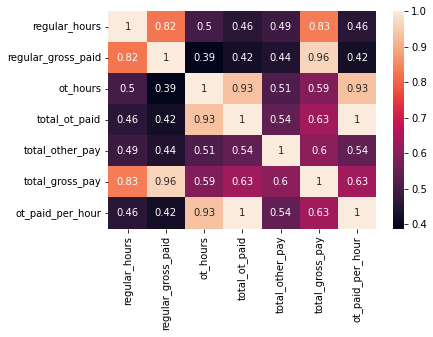

In [14]:
# Covariance Matrix
corr = results_df.corr()
sns.heatmap(corr, annot=True)


### Analysis:
Using the covariance matrix we can see some clear correlations such as the regular hours has a huge impact on regular gross paid with a high correlation of 0.82. Same goes for the correlation between total gross pay and regular gross_paid which means that the regular gross paid is pretty much included in the total gross pay. We can see that the two things that affect the total gross pay the most is the regular hours and the regular gross paid.

We can also see that this correlation matrix makes a lot of sense to our intuition since our calculated feature of ot paid per hour is almost entirely correlated to ot_hours and total_ot_paid.

## Part II: Summary Statistics

In [15]:
# Summary Statistics
results_df.describe()

,regular_hours,regular_gross_paid,ot_hours,total_ot_paid,total_other_pay,total_gross_pay,ot_paid_per_hour
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,900.131178,34303.776386,72.597479,3855.974962,2435.225805,40594.977153,3855.974962
std,892.984956,37328.754259,173.969284,10199.752878,5550.958215,45746.216175,10199.752878
min,-490.000000,-117989.060000,-209.000000,-8517.120000,-106132.000000,-117989.060000,-8517.120000
25%,0.000000,660.000000,0.000000,0.000000,0.000000,675.000000,0.000000
50%,479.500000,19888.490000,0.000000,0.000000,0.000000,20578.600000,0.000000
75%,1825.000000,63915.690000,20.000000,818.487500,2465.645000,72430.097500,818.487500
max,4171.430000,488000.000000,3347.500000,217915.940000,214703.140000,488000.000000,217915.940000


#### Analysis
If we look at the minimum for these features we can see that there are negative values which can be kinda strange to explain why total_gross_pay is negative. A couple of reasons this could happen explained here https://kb.blackbaud.com/knowledgebase/Article/49719,
however for our purposes we might want to remove these negative amounts and see how it changes our summary statistics.

In [16]:
# Lets see how many of these rows contain values where the total_gross_pay is negative (2840), we can also check which jobs these are but we'll see its not exactly specific to any one job
negative_df = results_df[results_df['total_gross_pay'] <= 0]
negative_df.shape[0]



2840

In [17]:
# Lets go ahead and just remove those rows then
positive_pay_df = results_df[results_df['total_gross_pay'] > 0]

In [18]:
positive_pay_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997160 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   fiscal_year                 997160 non-null  object 
 1   payroll_number              622187 non-null  object 
 2   agency_name                 997160 non-null  object 
 3   last_name                   996904 non-null  object 
 4   first_name                  996902 non-null  object 
 5   mid_init                    519432 non-null  object 
 6   agency_start_date           997097 non-null  object 
 7   work_location_borough       887674 non-null  object 
 8   title_description           997143 non-null  object 
 9   leave_status_as_of_july_31  997160 non-null  object 
 10  regular_hours               997160 non-null  float64
 11  regular_gross_paid          997160 non-null  float64
 12  ot_hours                    997160 non-null  float64
 13  total_ot_paid 

Using the info() we can gather that there is missing data mostly from the feature work_location_borough. We will need to look into how to handle it to start we can probably just drop the missing title_descriptions since they are oly a small amount but for work_location we will have to do something else we can start by looking at what uniques that feature can take on.

In [19]:

# TODO: PICK UP HERE TO IMPLEMENT FINDING UNIQUES OF WORK LOCATION 
positive_pay_df.groupby('work_location_borough').describe()

regular_hours                                   \
                              count         mean         std     min   
work_location_borough                                                  
ALBANY                         11.0  1408.659091  624.316709  125.75   
BRONX                       76088.0  1120.787570  837.822842 -126.00   
BROOKLYN                    98941.0  1235.854302  831.763258 -210.00   
Bronx                         935.0  1603.062545  461.752587    0.00   
DELAWARE                       10.0  1126.259000  726.392024  129.98   
MANHATTAN                  495722.0   632.026827  832.070932 -140.00   
NASSAU                        285.0   793.715298  748.468477    0.00   
ORANGE                         19.0   984.725263  912.872573    0.00   
OTHER                          15.0   225.755333  448.147597    0.00   
QUEENS                     198056.0  1278.292713  861.664303 -168.00   
RICHMOND                    17519.0  1552.190515  676.778902  -40.00   
SULLIVAN                       23.0  1135.329565  873.163248    0.00   
WESTCHESTER                    50.0  1540.130800  456.639943  140.00   

                                                               \
                            25%       50%        75%      max   
work_location_borough                                           
ALBANY                 1069.750  1820.000  1825.0000  1830.00   
BRONX                   175.000  1548.125  1825.0000  2245.72   
BROOKLYN                216.250  1790.000  1917.8500  2936.00   
Bronx                  1506.375  1825.000  1825.0000  2085.72   
DELAWARE                416.500  1325.190  1804.1725  1825.00   
MANHATTAN                 0.000     0.000  1785.0000  2401.12   
NASSAU                  182.500   188.580  1664.0000  1830.00   
ORANGE                    0.000  1790.000  1825.0000  1830.00   
OTHER                    75.000   160.000   160.0000  1825.00   
QUEENS                  240.000  1820.000  2080.0000  4160.00   
RICHMOND               1534.280  1820.000  2077.7200  2192.00   
SULLIVAN                101.375  1820.000  1825.0000  1830.00   
WESTCHESTER            1458.500  1805.000  1820.0000  1830.00   

                      regular_gross_paid                ... total_gross_pay  \
                                   count          mean  ...             75%   
work_location_borough                                   ...                   
ALBANY                              11.0  97492.202727  ...     127590.6750   
BRONX                            76088.0  42152.906910  ...      78058.8100   
BROOKLYN                         98941.0  46512.404278  ...      90083.7100   
Bronx                              935.0  53847.431369  ...      65104.8500   
DELAWARE                            10.0  28837.001000  ...      42734.8750   
MANHATTAN                       495722.0  25268.321611  ...      53791.1000   
NASSAU                             285.0  31411.661930  ...      69452.6400   
ORANGE                              19.0  31393.463684  ...      60813.7700   
OTHER                               15.0  15496.092000  ...      23611.8400   
QUEENS                          198056.0  48329.628473  ...      98679.9325   
RICHMOND                         17519.0  57746.000779  ...     108847.3150   
SULLIVAN                            23.0  31760.641739  ...      54031.0400   
WESTCHESTER                         50.0  59100.221000  ...      74110.0450   

                                 ot_paid_per_hour                              \
                             max            count          mean           std   
work_location_borough                                                           
ALBANY                 131661.95             11.0      0.000000      0.000000   
BRONX                  347322.24          76088.0   4491.045553  10480.060555   
BROOKLYN               488000.00          98941.0   5868.746439  11425.198841   
Bronx                  195879.42            935.0   1027.743519   3495.461423


We can see that we will need to do some preprocessing as there are two bronx locations one with capitalized and one not. WE also have some places that are not in NYC like Delaware and Albany and some that don't have too many workers so we will need to either oversample or drop them entirely since we probably aren't interested in NASSAU, ORANGE, OTHER, SULLIVAN, WESTCHESTER and ALBANY. There is also a case that RICHMOND (Staten Island) is not really part of NYC but we'll just include it due to them having a significant amount of counts.

In [20]:
# TODO: clean_DF IS THE dataset clean of any nulls in the dataset that is of interest
clean_df = positive_pay_df[~(positive_pay_df['work_location_borough']==None)]

clean_df['work_location_borough'] = clean_df['work_location_borough'].replace('Bronx', 'BRONX')

interested_work_location_boroughs = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'RICHMOND']

clean_df = clean_df[clean_df['work_location_borough'].isin(interested_work_location_boroughs)]

# We will also want to take a look at removing any negative over time hours and other features where it doesn't
# make sense to have negative values
clean_df = clean_df[clean_df['ot_hours'] >= 0]
clean_df = clean_df[clean_df['regular_gross_paid'] >= 0]
clean_df = clean_df[clean_df['total_gross_pay'] >= 0]

In [21]:
clean_df.groupby('work_location_borough')['total_gross_pay'].describe()

,count,mean,std,min,25%,50%,75%,max
work_location_borough,,,,,,,,
BRONX,76982.0,49679.298784,43932.235364,1.136868e-13,8700.4275,43862.435,77887.7275,347322.24
BROOKLYN,98888.0,56279.157604,45612.142487,4.000000e-02,11668.1925,52854.395,90105.5250,488000.00
MANHATTAN,495556.0,27941.125079,40608.912124,2.000000e-02,500.0000,1075.000,53805.6200,478302.31
QUEENS,197899.0,61238.661355,49304.867368,3.000000e-02,12757.2700,58246.340,98715.8400,445490.73
RICHMOND,17504.0,76687.918219,44904.917316,2.800000e-01,43982.4725,79385.760,108851.4325,286396.44


We notice that there is something unusual that the mean for employees in Manhattan seem to be lower than usual. If we look at the 25% and 50% we notice there is a lot of zeros. So lets take a look at the data more carefully to see whats going on here.

There are employees in this dataset that have 0 regular hours which may contribute to the very low 50% total gross pay to the reason a lot of these 0 hours are from election workers or non teaching adjuncts. So lets remove those that have no regular hours and no over time hours

In [22]:
clean_df = clean_df[(clean_df['regular_hours']!=0) & (clean_df['ot_hours']!=0)]

In [23]:
clean_df.groupby('work_location_borough')['total_gross_pay'].describe()

,count,mean,std,min,25%,50%,75%,max
work_location_borough,,,,,,,,
BRONX,29034.0,75629.939528,38564.484233,180.32,47430.1750,68831.880,102903.9550,347322.24
BROOKLYN,44960.0,82369.593158,38706.286553,378.00,52684.2850,78436.275,109624.9475,331251.20
MANHATTAN,81558.0,69822.817450,37073.918973,0.37,43945.3725,64126.680,93149.1250,337564.66
QUEENS,102319.0,89556.511038,40861.433347,177.68,58674.1700,87337.110,116136.4600,410812.78
RICHMOND,12158.0,92281.614335,37992.383835,414.18,64829.7975,95519.780,115551.6925,286396.44


*Analysis:* So after removing those that have both 0 regular hours and 0 over time hours we now see more or so the same total gross pay. Manhattan actually seems to have the lowest mean of the boroughs which is a little surprising. However looking at the median we see that it is also the lowest. One thing to note here is the difference between median and mean for the Bronx is the greatest out of the 5 boroughs suggesting higher income inequality.

In [24]:
# Looking at the ot hours
clean_df.groupby('work_location_borough')['ot_hours'].describe()

,count,mean,std,min,25%,50%,75%,max
work_location_borough,,,,,,,,
BRONX,29034.0,230.452145,230.554889,0.12,45.50,179.75,330.5000,2301.50
BROOKLYN,44960.0,234.989703,214.343707,0.12,56.75,198.00,345.0000,2338.02
MANHATTAN,81558.0,169.673701,216.361011,0.25,15.00,77.25,265.0000,2736.67
QUEENS,102319.0,305.946830,276.221844,0.10,88.85,243.50,439.6650,3147.00
RICHMOND,12158.0,300.635978,257.291369,0.25,105.00,254.00,408.9925,1833.00


<AxesSubplot:>

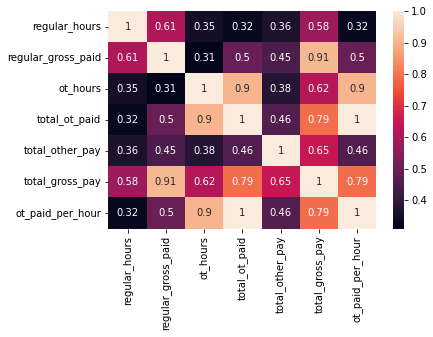

In [25]:
# Comparing the two covariance matrices
clean_corr = clean_df.corr()
sns.heatmap(clean_corr, annot=True)

## Part III: Modeling

Now that our data set is for the most part ready we can kind of gauge how we want to go about using the features to predict total gross pay. We don't want to use any of the features that we used to calculate total gross pay as that would defeat the purpose since those features are highly correlated. However we can use regular hours, ot hours and job description to try to predict the total gross pay.

#### ETL PipeLine

In order to prep our data we still need to do some data preperation such as categorical encoding and replacing binary categories.

In [26]:
model_df = clean_df[['total_gross_pay','title_description', 'regular_hours', 'ot_hours']]

In [27]:
# We want to see how much of each title description

model_df.groupby('title_description').describe()

total_gross_pay                 \
                                                      count           mean   
title_description                                                            
*ADM DIR FLEET MAINTENANCE - NM                         3.0  146967.013333   
*ASSOCIATE EDUCATION OFFICER                           10.0   93003.614000   
*ATTORNEY AT LAW                                        7.0  115426.745714   
*CERTIFIED DATABASE ADMINISTRATOR                       7.0  112266.171429   
*CERTIFIED LOCAL AREA NETWORK ADMINISTRATOR            10.0  108836.125000   
...                                                     ...            ...   
WARDEN-DEPUTY WARDEN                                   33.0  144797.216667   
WARDEN-DEPUTY WARDEN TED < 11/1/92                     16.0  151504.791875   
WELDER                                                117.0  159881.677949   
WORKER'S COMPENSATION BENEFITS EXAMINER                 3.0   69912.253333   
YOUTH DEVELOPMENT SPECIALIST                         1595.0   44444.091342   

                                                                      \
                                                      std        min   
title_description                                                      
*ADM DIR FLEET MAINTENANCE - NM              24722.999898  131706.07   
*ASSOCIATE EDUCATION OFFICER                 20227.019068   47963.72   
*ATTORNEY AT LAW                             11505.173795  103389.97   
*CERTIFIED DATABASE ADMINISTRATOR             9994.542975   99843.18   
*CERTIFIED LOCAL AREA NETWORK ADMINISTRATOR  16590.861418   86352.35   
...                                                   ...        ...   
WARDEN-DEPUTY WARDEN                         27713.688228   33860.92   
WARDEN-DEPUTY WARDEN TED < 11/1/92           17737.439509  126370.41   
WELDER                                       41778.875818   18248.52   
WORKER'S COMPENSATION BENEFITS EXAMINER       6415.653354   62513.71   
YOUTH DEVELOPMENT SPECIALIST                 25821.004579     592.56   

                                                                     \
                                                    25%         50%   
title_description                                                     
*ADM DIR FLEET MAINTENANCE - NM              132704.835  133703.600   
*ASSOCIATE EDUCATION OFFICER                  89803.905   93670.025   
*ATTORNEY AT LAW                             107610.085  112268.510   
*CERTIFIED DATABASE ADMINISTRATOR            105903.775  109762.840   
*CERTIFIED LOCAL AREA NETWORK ADMINISTRATOR   95897.695  106415.350   
...                                                 ...         ...   
WARDEN-DEPUTY WARDEN                         133568.190  140813.580   
WARDEN-DEPUTY WARDEN TED < 11/1/92           137356.245  151229.410   
WELDER                                       131897.930  157729.270   
WORKER'S COMPENSATION BENEFITS EXAMINER       67899.235   73284.760   
YOUTH DEVELOPMENT SPECIALIST                  22030.980   42425.490   

                                                                     \
                                                     75%        max   
title_description                                                     
*ADM DIR FLEET MAINTENANCE - NM              154597.4850  175491.37   
*ASSOCIATE EDUCATION OFFICER                 104418.8825  124342.80   
*ATTORNEY AT LAW                             120254.3400  136599.89   
*CERTIFIED DATABASE ADMINISTRATOR            117630.5900  129188.45   
*CERTIFIED LOCAL AREA NETWORK ADMINISTRATOR  123415.2000  130993.10   
...                                                  ...        ...   
WARDEN-DEPUTY WARDEN                         155041.2700  208606.80   
WARDEN-DEPUTY WARDEN TED < 11/1/92           157723.6225  193907.82   
WELDER                                       180675.8200  294375.28   
WORKER'S COMPENSATION BENEFITS EXAMINER       73611.5250   73938.29   
YOUTH DEVELOPMENT SPECIA

In [28]:
# We can filter out for jobs that don't have many data points for which may increase accuracy.
for i in model_df['title_description'].unique():
    if model_df[(model_df['title_description']==i)].shape[0] > 100:
        pass
    else:
        model_df = model_df[(model_df['title_description']!=i)]


In [29]:
model_df.groupby('title_description').describe()

total_gross_pay                 \
                                                       count           mean   
title_description                                                             
*COOK                                                  379.0   44822.411794   
ACCOUNTANT                                             185.0   66090.617730   
ADM MANAGER-NON-MGRL                                   818.0   83096.022103   
ADM MANAGER-NON-MGRL FROM M1/M2                        524.0   81765.297137   
ADMIN COMMUNITY RELATIONS SPECIALIST                   168.0   91956.149881   
...                                                      ...            ...   
VOTING MACHINE TECHNICIAN                              711.0   50001.149325   
WARDEN-ASSISTANT DEPUTY WARDEN                         294.0  166832.283333   
WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92           354.0  176012.133051   
WELDER                                                 117.0  159881.677949   
YOUTH DEVELOPMENT SPECIALIST                          1595.0   44444.091342   

                                                                      \
                                                       std       min   
title_description                                                      
*COOK                                         11379.741324   2000.49   
ACCOUNTANT                                    19933.524996   4808.75   
ADM MANAGER-NON-MGRL                          20130.194103   2656.06   
ADM MANAGER-NON-MGRL FROM M1/M2               19774.359584  10905.33   
ADMIN COMMUNITY RELATIONS SPECIALIST          26006.037151   3020.11   
...                                                    ...       ...   
VOTING MACHINE TECHNICIAN                     14427.929116   1929.79   
WARDEN-ASSISTANT DEPUTY WARDEN                36444.781575   6274.24   
WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92  41576.437876  42350.15   
WELDER                                        41778.875818  18248.52   
YOUTH DEVELOPMENT SPECIALIST                  25821.004579    592.56   

                                                                       \
                                                      25%         50%   
title_description                                                       
*COOK                                          42536.3500   48228.000   
ACCOUNTANT                                     54171.2500   70092.620   
ADM MANAGER-NON-MGRL                           71779.9575   81518.620   
ADM MANAGER-NON-MGRL FROM M1/M2                68673.8200   77261.180   
ADMIN COMMUNITY RELATIONS SPECIALIST           76255.4925   88429.995   
...                                                   ...         ...   
VOTING MACHINE TECHNICIAN                      41749.3900   49697.790   
WARDEN-ASSISTANT DEPUTY WARDEN                143112.1100  160384.760   
WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92  150018.1950  173224.755   
WELDER                                        131897.9300  157729.270   
YOUTH DEVELOPMENT SPECIALIST                   22030.9800   42425.490   

                                                                      \
                                                      75%        max   
title_description                                                      
*COOK                                          51376.5300   68203.29   
ACCOUNTANT                                     78192.8500  114194.85   
ADM MANAGER-NON-MGRL                           93623.8825  193163.82   
ADM MANAGER-NON-MGRL FROM M1/M2                89784.2225  180626.58   
ADMIN COMMUNITY RELATIONS SPECIALIST          103856.5400  187662.08   
...                                                   ...        ...   
VOTING MACHINE TECHNICIAN                      58399.2700  119990.38   
WARDEN-ASSISTANT DEPUTY WARDEN                186396.0025  275064.15   
WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92  205032.7700  314412.18   
WELDER                                    

#### Forcasting

In [ ]:
# We want to prep our data for forcasting how particular jobs have increased over time
# We want to make sure we have enough data points for each title description to make accurate forcasts
forcast_df = clean_df

In [30]:
# Categorical Encoding
encoded_model_df = pd.get_dummies(model_df, columns=["title_description"])


In [31]:
# TODO: Categorical Encoding 
encoded_model_df.head()

,total_gross_pay,regular_hours,ot_hours,title_description_*COOK,title_description_ACCOUNTANT,title_description_ADM MANAGER-NON-MGRL,title_description_ADM MANAGER-NON-MGRL FROM M1/M2,title_description_ADMIN COMMUNITY RELATIONS SPECIALIST,title_description_ADMIN INSPECTOR,title_description_ADMINISTRATIVE ASSISTANT,...,title_description_TRACTOR OPERATOR,title_description_TRAFFIC CONTROL INSPECTOR,title_description_TRAFFIC DEVICE MAINTAINER,title_description_TRAINER ASSISTANT,title_description_TRANSPORTATION SPECIALIST,title_description_VOTING MACHINE TECHNICIAN,title_description_WARDEN-ASSISTANT DEPUTY WARDEN,title_description_WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,title_description_WELDER,title_description_YOUTH DEVELOPMENT SPECIALIST
1,54990.31,1680.0,17.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,63617.24,1820.0,77.50,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,64401.21,1820.0,2.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,64398.23,1820.0,2.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,60492.28,1820.0,18.75,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
# Dependent variable
y = encoded_model_df['total_gross_pay']
y

1          54990.31
3          63617.24
15         64401.21
16         64398.23
18         60492.28
            ...    
999992    148255.01
999993     16042.10
999996     43832.79
999997    118057.88
999999    108265.06
Name: total_gross_pay, Length: 261628, dtype: float64

In [33]:
# Independent variable
X = encoded_model_df.drop(columns=['total_gross_pay'])
X

,regular_hours,ot_hours,title_description_*COOK,title_description_ACCOUNTANT,title_description_ADM MANAGER-NON-MGRL,title_description_ADM MANAGER-NON-MGRL FROM M1/M2,title_description_ADMIN COMMUNITY RELATIONS SPECIALIST,title_description_ADMIN INSPECTOR,title_description_ADMINISTRATIVE ASSISTANT,title_description_ADMINISTRATIVE ASSOCIATE,...,title_description_TRACTOR OPERATOR,title_description_TRAFFIC CONTROL INSPECTOR,title_description_TRAFFIC DEVICE MAINTAINER,title_description_TRAINER ASSISTANT,title_description_TRANSPORTATION SPECIALIST,title_description_VOTING MACHINE TECHNICIAN,title_description_WARDEN-ASSISTANT DEPUTY WARDEN,title_description_WARDEN-ASSISTANT DEPUTY WARDEN TED < 11/1/92,title_description_WELDER,title_description_YOUTH DEVELOPMENT SPECIALIST
1,1680.00,17.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1820.00,77.50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1820.00,2.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16,1820.00,2.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,1820.00,18.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999992,1668.58,1080.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999993,379.43,139.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999996,1825.00,68.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
999997,1825.00,120.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# using svm model and testing the estimator using cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [35]:
# TODO: Replacing binary categories

Machine Learning PipeLine

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier


test_df = encoded_model_df.sample(n=50000, random_state=42)

# Changing feature names so that xgboost doesn't throw an error
test_df.columns = test_df.columns.str.replace('*', 'a')
test_df.columns = test_df.columns.str.replace('<', 'b')
test_df.columns = test_df.columns.str.replace('[', 'c')
test_df.columns = test_df.columns.str.replace(']', 'd')
test_df.columns = test_df.columns.str.replace(',', 'e')

X = test_df.drop(columns=['total_gross_pay'])
y = test_df['total_gross_pay']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)





/tmp/ipykernel_362682/436682176.py:16: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_df.columns = test_df.columns.str.replace('*', 'a')
/tmp/ipykernel_362682/436682176.py:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_df.columns = test_df.columns.str.replace('[', 'c')
/tmp/ipykernel_362682/436682176.py:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  test_df.columns = test_df.columns.str.replace(']', 'd')


In [ ]:
# Creating array that holds each unique title_description

unique_titles = []
for i in test_df['title_description'].unique():
    unique_titles.append(i)


In [ ]:
# We want to make models for each one and check to see if title_description can be a good way to predict salary
# TODO: Pick up here to finish making models for each title description

estimators = []

for i in unique_titles:
    test_this_model = test_df[test_df['title_description'] == i]
    
    est = 
        


In [37]:
#cross_val_score(RandomForestRegressor(), X, y)

In [38]:
#clf = SVR(kernel='poly')
#cross_val_score(clf, X_train, y_train)

In [ ]:
# Trying out models with specific title descriptions




In [39]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

/home/salman1567/.local/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/salman1567/.local/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[18:31:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 